In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
from IPython.core.debugger import set_trace
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import re
import string
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam
plt.style.use(style="seaborn")
%matplotlib inline

In [ ]:
csv_file = ('/content/gdrive/My Drive/kickstarter_data_with_features.csv')
dataframe = pd.read_csv(csv_file)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (29,30,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
##Multiple functions for cleaning data

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_number(text):
    newstring = re.sub(r'[0-9]+', '', text)
    return newstring


def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)


def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)


In [ ]:
dataframe['blurb']=dataframe['blurb'].astype("string")

In [ ]:
dataframe = dataframe[['blurb','state']]

In [ ]:
dataframe = dataframe[dataframe['state'].isin(['successful', 'failed'])]

In [ ]:
dataframe['state'] = dataframe['state'].replace({'failed': 0, 'successful': 1})

In [ ]:
stop = set(stopwords.words("english"))
def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]

    return " ".join(text)

In [ ]:
dataframe['blurb'] = dataframe['blurb'].map(remove_stopwords)

In [ ]:
dataframe = dataframe.dropna()

In [ ]:
from sklearn.model_selection import train_test_split
X = dataframe.drop('state', axis=1)
Y = dataframe.state
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=123)

In [ ]:
text_train = X_train.blurb

In [ ]:
from collections import Counter
# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        i = remove_punct(i)
        i = remove_emoji(i)
        i = remove_URL(i)
        i = remove_html(i)
        i = remove_number(i)
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
counter = counter_word(text_train)

In [ ]:
num_words = len(counter)

In [ ]:
from keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(text_train)

In [ ]:
word_index = tokenizer.word_index

In [ ]:
train_sequences = tokenizer.texts_to_sequences(text_train)

In [ ]:
def find_max_list(list):
    list_len = [len(i) for i in list]
    print(max(list_len))
max_length = find_max_list(train_sequences)

26


In [ ]:
from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)

In [ ]:
train_padded[0]

array([ 172,   77,  517, 7038,  202,    2, 1592, 3632,  103, 1666, 2956,
        701,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0], dtype=int32)

In [ ]:
text_test = X_test.blurb

In [ ]:
test_sequences = tokenizer.texts_to_sequences(text_test)

In [ ]:
max_length_test = find_max_list(test_sequences)

23


In [ ]:
test_padded = pad_sequences(
    test_sequences, maxlen=max_length_test, padding="post", truncating="post"
)

In [ ]:
print(X_train.blurb[0])
print(train_sequences[0])

mts asl curriculum workbook reproducible study book build early literacy academic skills primary school age children.
[172, 77, 517, 7038, 202, 2, 1592, 3632, 103, 1666, 2956, 701]


In [ ]:
print(f"Shape of train {train_padded.shape}")
print(f"Shape of test {test_padded.shape}")

Shape of train (12203, 26)
Shape of test (5231, 23)


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

model = Sequential()

model.add(Embedding(num_words, 32, input_length=max_length))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(1, activation="sigmoid"))


optimizer = Adam(learning_rate=3e-4)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          765664    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 790,561
Trainable params: 790,561
Non-trainable params: 0
_________________________________________________________________


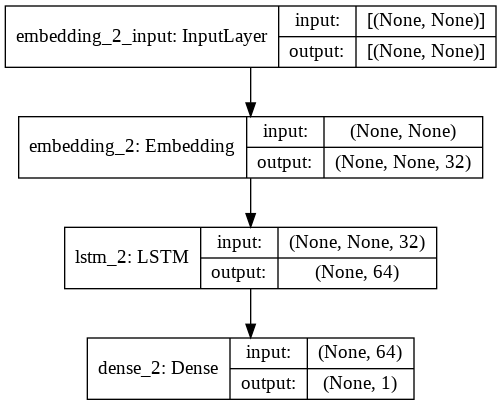

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [ ]:

history = model.fit(
    train_padded, y_train, epochs=10, validation_data=(test_padded, y_test))

Epoch 1/10
382/382 [==============================] - 12s 27ms/step - loss: 0.6399 - accuracy: 0.6635 - val_loss: 0.5748 - val_accuracy: 0.7031
Epoch 2/10
382/382 [==============================] - 10s 25ms/step - loss: 0.4785 - accuracy: 0.7810 - val_loss: 0.5693 - val_accuracy: 0.6985
Epoch 3/10
382/382 [==============================] - 10s 25ms/step - loss: 0.3597 - accuracy: 0.8552 - val_loss: 0.6339 - val_accuracy: 0.6760
Epoch 4/10
382/382 [==============================] - 10s 25ms/step - loss: 0.2290 - accuracy: 0.9165 - val_loss: 0.7495 - val_accuracy: 0.6666
Epoch 5/10
382/382 [==============================] - 10s 25ms/step - loss: 0.1632 - accuracy: 0.9470 - val_loss: 0.8623 - val_accuracy: 0.6502
Epoch 6/10
382/382 [==============================] - 10s 25ms/step - loss: 0.1122 - accuracy: 0.9647 - val_loss: 1.0246 - val_accuracy: 0.6494
Epoch 7/10
382/382 [==============================] - 10s 25ms/step - loss: 0.0923 - accuracy: 0.9721 - val_loss: 0.9764 - val_accuracy:

In [ ]:
results = model.evaluate(test_padded, y_test, batch_size=128)

41/41 [==============================] - 0s 10ms/step - loss: 1.3814 - accuracy: 0.6412


In [ ]:
metrics_df = pd.DataFrame(history.history)
metrics_df

,loss,accuracy,val_loss,val_accuracy
0,0.612188,0.678194,0.574783,0.703116
1,0.475673,0.778989,0.569328,0.698528
2,0.351853,0.856265,0.633863,0.675970
3,0.245051,0.909858,0.749474,0.666603
4,0.173786,0.940015,0.862282,0.650163
5,0.129492,0.957388,1.024586,0.649398
6,0.098761,0.968860,0.976438,0.643854
7,0.080163,0.976563,1.085888,0.653412
8,0.064801,0.981234,1.347814,0.631237
9,0.058584,0.982627,1.381423,0.641178


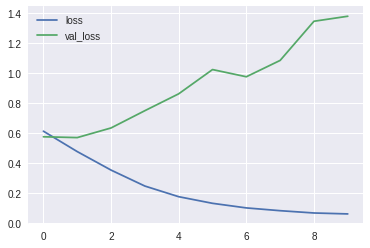

In [ ]:
metrics_df[["loss","val_loss"]].plot();
#### OVERFITTING!